# [X-HEC] - Seance 5 - Advanced word representations 



# Outline 
1. [Word2vec From Scratch](#Word2vec-From-Scratch) 30'
*  [Skipgram with negative sampling using Tensorflow](#Skipgram-with-negative-sampling-using-Tensorflow) 30'
*  [Learn representations of reviewers with Node2vec](#Learn-representations-of-reviewers-with-Node2vec) 15'
*  [Improve Sentiment model coupling reviewer embeddings and word embeddigns](#Improve-your-sentiment-model-coupling-reviewer-embeddings-and-word-embeddigns) 30'

In [1]:
#!pip install networkx
#!pip install gensim
#!pip install nltk
#!pip install joblib
#!pip install tqdm
#!pip install sklearn
#!conda install pytorch
#!conda install torchtext

In [2]:
import pandas as pd 
import numpy as np
import re
from nltk.tokenize import word_tokenize
from collections import defaultdict
import random
from ast import literal_eval

# Word2vec From Scratch

In this notebook you will be coding your own word2vec model from (almost) scratch

<img src="skipgram.png"/>

In this notebook you are developpping your own Skipgram model. 
Using a class with the following hyperparameters: 


## Skipgram Model 

### 1. Forward pass

* $W$ : central word vector
* $x$ : one hot encoded vector

$$h = x^TW \tag{1}$$
Since $x$ is a one-hot vector $h$ is just $k^{th}$ row of matrix $W$ 

Vector representation for the central word is then defined by:
$$v_c = x_t^TW \tag{2}$$

We the compute the dot product $u_o^Tv_c$
$$u_c = W'^TW^Tx \tag{3}$$


$$p(w_o \mid w_c) = Softmax(\boldsymbol{u}_o^\top \boldsymbol{v}_c) $$

$$p(w_o \mid w_c) = \frac{\text{exp}(\boldsymbol{u}_o^\top \boldsymbol{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\boldsymbol{u}_i^\top \boldsymbol{v}_c)} \tag{4}$$

### 2. Loss Definition: Negative log likelihood

$$\mathcal{L} = -\log p(w_t | w_c) $$

$$\mathcal{L} = -\log(\frac{\exp(u_j)}{\sum_j{\exp(u_i)}})$$

$$\mathcal{L} = -u_j + C * \log \sum{\exp(u_i)} \tag{6}$$

### 3. Compute the classification error 

$$EI_j=\sum_{c=1}^{C} (y_{c,j}−t_{c,j})$$


### 4. Backpropagation (optional)
#### Compute gradients
$$\mathcal{L} = -\log p(w_t | w_c) $$

$$\mathcal{L} = -\log\prod_{c=1}^{C}(\frac{\exp(u_j)}{\sum_j{\exp(u_i)}})$$

$$\mathcal{L} = -\sum_{c=1}^{C}u_j + C * \log \sum_{j=1}^{V}{\exp(u_i)} \tag{6}$$

#### update weights 

$$w_{i,j}^{'(new)} = w_{i,j}^{'(old)} - \eta EI_j h_i \tag{7}$$

$$w_{i,j}^{(new)} = w_{i,j}^{(old)} - \eta \frac{{\partial \mathcal{L}}}{\partial W}  \tag{8}$$
### 5. Train the model with SGD
for each training example (equivalent to an epoch here)  we perform the following steps: 
1. Forward pass the $x_t$ input 
2. Compute the error
3. Backpropagate the gradient
3. Update the loss 

In [6]:
from w2v_utils import *

In [7]:


class SkipGramNumpy():
    def __init__ (self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
    
    
    # GENERATE TRAINING DATA
    def generate_training_data(self, settings, corpus):

        # GENERATE WORD COUNTS
        word_counts = defaultdict(int)
        for row in corpus:
            for word in row:
                word_counts[word] += 1

        self.v_count = len(word_counts.keys())

        # GENERATE LOOKUP DICTIONARIES
        self.words_list = sorted(list(word_counts.keys()),reverse=False)
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))

        training_data = []
        # CYCLE THROUGH EACH SENTENCE IN CORPUS
        for sentence in corpus:
            sent_len = len(sentence)

            # CYCLE THROUGH EACH WORD IN SENTENCE
            for i, word in enumerate(sentence):
                
                #w_target  = sentence[i]
                w_target = self.word2onehot(sentence[i])

                # CYCLE THROUGH CONTEXT WINDOW
                w_context = []
                for j in range(i-self.window, i+self.window+1):
                    if j!=i and j<=sent_len-1 and j>=0:
                        w_context.append(self.word2onehot(sentence[j]))
                training_data.append([w_target, w_context])
        return np.array(training_data)

    # CONVERT WORD TO ONE HOT ENCODING
    def word2onehot(self, word):
        word_vec = [0 for i in range(0, self.v_count)]
        word_index = self.word_index[word]
        word_vec[word_index] = 1
        return word_vec


    # FORWARD PASS
    def forward_pass(self, x):
        #### FILL THE BLANK(S) ####
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = softmax(u)
        return y_c, h, u
        ############## END
                

    # BACKPROPAGATION
    def backprop(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
        ############## YOUR CODE HERE
        # UPDATE WEIGHTS
        self.w1 = self.w1 - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        ############## END


    # TRAIN W2V model
    def train(self, training_data):
        # INITIALIZE WEIGHT MATRICES
        self.w1 = np.random.uniform(-0.8, 0.8, (self.v_count, self.n))     # embedding matrix
        self.w2 = np.random.uniform(-0.8, 0.8, (self.n, self.v_count))     # context matrix
        
        # CYCLE THROUGH EACH EPOCH
        for i in range(0, self.epochs):

            self.loss = 0

            # CYCLE THROUGH EACH TRAINING SAMPLE
            for w_t, w_c in training_data:
                
                #### FILL THE BLANK(S) ####             
                # FORWARD PASS
                y_pred, h, u = self.forward_pass(w_t)
                
                
                # CALCULATE ERROR
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)

                # BACKPROPAGATION
                self.backprop(EI, h, w_t)

                # CALCULATE LOSS
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
                
                ############## END
            print('EPOCH:',i, 'LOSS:', self.loss)


    # input a word, returns a vector (if available)
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w


    # input word, returns top [n] most similar words
    def word_sim(self, word, top_n):
        
        w1_index = self.word_index[word]
        v_w1 = self.w1[w1_index]

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            
            #### Cosine distance
            v_w2 = self.w1[i]
            cosine_sim = cosine_similarity(v_w1, v_w2)
            
            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = [(k,v) for k, v in sorted(word_sim.items(), key=lambda item: item[1], reverse=True)]
        for word, sim in words_sorted[:top_n]:
            print(word, sim)


In [8]:
# EXAMPLE RUN 

settings = {}
settings['n'] = 5                   # dimension of word embeddings
settings['window_size'] = 2         # context window +/- center word
settings['min_count'] = 0           # minimum word count
settings['epochs'] = 5000           # number of training epochs
settings['neg_samp'] = 10           # number of negative words to use during training
settings['learning_rate'] = 0.01    # learning rate
np.random.seed(0)                   # set the seed for reproducibility

toy_corpus = [['learning','about','word','embedding','with','capgemini','is', 'awesome']]

# INITIALIZE W2V MODEL
w2v = SkipGramNumpy()

# generate training data
training_data = w2v.generate_training_data(settings, toy_corpus)

# train word2vec model
w2v.train(training_data)

EPOCH: 0 LOSS: 53.48615743759953
EPOCH: 1 LOSS: 53.182067199975236
EPOCH: 2 LOSS: 52.890572978770926
EPOCH: 3 LOSS: 52.610501959259864
EPOCH: 4 LOSS: 52.340810392382444
EPOCH: 5 LOSS: 52.08056672968439
EPOCH: 6 LOSS: 51.82893740176047
EPOCH: 7 LOSS: 51.58517476879726
EPOCH: 8 LOSS: 51.34860686500323
EPOCH: 9 LOSS: 51.118628631778265
EPOCH: 10 LOSS: 50.89469439207087
EPOCH: 11 LOSS: 50.67631136402152
EPOCH: 12 LOSS: 50.46303404836688
EPOCH: 13 LOSS: 50.254459353219794
EPOCH: 14 LOSS: 50.05022234330539
EPOCH: 15 LOSS: 49.84999251972573
EPOCH: 16 LOSS: 49.65347055177652
EPOCH: 17 LOSS: 49.46038539497088
EPOCH: 18 LOSS: 49.270491739804925
EPOCH: 19 LOSS: 49.08356774437025
EPOCH: 20 LOSS: 48.89941301103062
EPOCH: 21 LOSS: 48.71784677331217
EPOCH: 22 LOSS: 48.53870626412797
EPOCH: 23 LOSS: 48.361845240646886
EPOCH: 24 LOSS: 48.187132644663286
EPOCH: 25 LOSS: 48.014451380343544
EPOCH: 26 LOSS: 47.84369719380794
EPOCH: 27 LOSS: 47.674777641227955
EPOCH: 28 LOSS: 47.507611134037695
EPOCH: 29 LO

## Notes about improvement you can make on this model

#### Subsampling frequent words

In text data, there are generally some words that appear at high frequencies, such "the", "a", and "in" in English. Generally speaking, in a context window, it is better to train the word embedding model when a word (such as "chip") and a lower-frequency word (such as "microprocessor") appear at the same time, rather than when a word appears with a higher-frequency word (such as "the"). Therefore, when training the word embedding model, we can perform subsampling[2] on the words. Specifically, each indexed word $w_i$ in the data set will drop out at a certain probability. The dropout probability is given as:

$$ \mathbb{P}(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

Here, $f(w_i)$ is the ratio of the instances of word $w_i$ to the total number of words in the data set, and the constant $t$ is a hyper-parameter (set to $10^{-4}$ in this experiment). As we can see, it is only possible to drop out the word $w_i$ in subsampling when $f(w_i) > t$. The higher the word's frequency, the higher its dropout probability.

#### Negative Sampling
We use negative sampling for approximate training. For a central and context word pair, we randomly sample $K$ noise words ($K=5$ in the experiment). According to the suggestion in the Word2vec paper, the noise word sampling probability $\mathbb{P}(w)$ is the ratio of the word frequency of $w$ to the total word frequency raised to the power of 0.75.

$$P(w_i)= \frac{ f(w_i)}{ \sum_{j=0}^n{f(w_j)} }$$

$$P(w_i)= \frac{ f(w_i)^{0.75} }{ \sum_{j=0}^n{(f(w_j)^{0.75} ) } }$$


| $c$ : context word | $t$ : word candiate | $y$: ground truth | eligible for sampling |
| ----- | ----- | ----- | ----- |
| restaurant | food | 1 | <div style="color:red">no</div> |
| restaurant | computer | 0 | <div style="color:green">yes</div> |
| restaurant | flower | 0 | <div style="color:green">yes</div> |
| restaurant | cat | 0 | <div style="color:green">yes</div> |

#### Word pairs or "Phrase" model

This way, we can form many reasonable phrases without greatly increasing the size of the vocabulary; in theory, we can train the Skip-gram model using all n-grams, but that would be too memory
intensive. Many techniques have been previously developed to identify phrases in the text; however,
it is out of scope of our work to compare them. We decided to use a simple data-driven approach,
where phrases are formed based on the unigram and bigram counts, using

$$score(w_i, w_j) = \frac{count(w_i, w_j) - \gamma}{count(w_i)*count(w_j)} $$

Gensim provides with an implementation for such n-gram modeling 
```python
from gensim.models.phrases import Phrases, Phraser

print(list(sentences)[0][:10])
['computer', 'human', 'interface', 'computer', 'response', 'survey', 'system', 'time', 'user', 'interface']

# Train a toy bigram model.
phrases = Phrases(sentences, min_count=1, threshold=1)
# Apply the trained phrases model to a new, unseen sentence.
phrases[['trees', 'graph', 'minors']]
['trees_graph', 'minors']
```

### Playing around with word vectors 

#### Get clean reviews dataset

In [3]:
def get_reviews_dataset():
    # Define data path
    DATA_PATH = './' #'../../data/'
    file_path = os.path.join(DATA_PATH, 'clean_full_graph.csv.gzip')

    # Read csv file with right parameters
    df = pd.read_csv(
        file_path,
        compression='gzip',
        low_memory=False,
        nrows=None,
        parse_dates=['review_date', 'review_date_diner']
    )
    df.review_content_clean = df.review_content_clean.apply(lambda x: literal_eval(x))
    return df 


In [72]:
df = get_reviews_dataset()
sentences = df.review_content_clean.tolist()

#### Train Word2vec and FastText

In [11]:
from gensim.models import Word2Vec, FastText
def get_word2vec_embeddings(sentences): 
    filepath = "word2vec.pkl"
    if os.path.exists(filepath):
        return Word2Vec.load(filepath)
    return Word2Vec(sentences)

def get_fasttext_embeddings(sentences):
    filepath = "fasttext.pkl"
    if os.path.exists(filepath):
        return FastText.load(filepath)
    return FastText(sentences)

w2v = get_word2vec_embeddings()
fastext = get_fasttext_embeddings()

In [103]:
#w2v.save("word2vec.pkl")
#fastext.save("fasttext.pkl")

#### Looking at most similar words (using cosine similarity)

What are the most similar words to restaurant with pre-trained Fastext  $$\vec{restaurant} \approx{} ?$$

In [24]:
#### FILL THE BLANK(S) ####


and word2vec ? 
$$\vec{restaurant} \approx{} ?$$

In [22]:
#### FILL THE BLANK(S) ####


Does our vector space capture semantic relationships between words such as "A is to B like C is to D" 

$$\vec{sushi} - \vec{japanese} + \vec{italian} \approx{} ?$$

In [2]:
#### FILL THE BLANK(S) ####


# 2. Skipgram with negative sampling using Tensorflow

In [ ]:
#Notebook Johan

# 3. Learn representations of reviewers with Node2vec

In [1]:
import gensim 
import os 
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt 
import nltk
from nltk import FreqDist
#from utils import *
from ast import literal_eval

#### 3. Use Node2Vec for learning an embedding for reviewers (5')
* Present the model parameters 
* Analyse the similarities between reviewers, 
* visualize the embedding space 
* cluster the users, do those cluster seem to have an interpretable meaning ? 
#### 4. Modify your text classifier architecture to incorpore the reviewer embeddings
#### 5. Analyze the results 


#### Build the Graph of reviewers 
You are going to build a graph where each node is represented by a reviewer, and an edge represents the reviewer 1 and reviewer 2 eating at the same restaurants. 


The output dataframe of ```create_graph_data()``` should look as follows: 


| reviewer_pseudo_1 | reviewer_pseudo_2 | rest_id | 
| ----------------- | ----------------- | ----------------- |
| bob | alice | resto_1 | 
| bob | john | resto_2 | 

We are going to use ```networkX``` for using its graph data structure, and plot some visualizations 

In [4]:
SAMPLE_SIZE = 20000

def create_graph_data(df): 
    
    interactions=df[['reviewer_pseudo', 'rest_id']]
    interactions = interactions.merge(interactions[['reviewer_pseudo', 'rest_id']], on='rest_id')
    ##Removing reviewers connected to themselves
    interactions = interactions[interactions['reviewer_pseudo_x']!=interactions['reviewer_pseudo_y']]
    ##Removing duplicate edges
    interactions.drop(interactions.loc[interactions['reviewer_pseudo_y']<interactions['reviewer_pseudo_x']].index.tolist(), inplace=True)
    ##Reordering columns
    interactions=interactions[['reviewer_pseudo_x','reviewer_pseudo_y','rest_id']].reset_index(drop=True)
    return interactions


#df = get_reviews_dataset()
interactions = create_graph_data(df.sample(SAMPLE_SIZE, random_state=42))

In [42]:
def construct_graph_from_interactions(interactions):
    G = nx.from_pandas_edgelist(interactions[["reviewer_pseudo_x", "reviewer_pseudo_y", "rest_id"]], 
                        source="reviewer_pseudo_x",
                       target = "reviewer_pseudo_y", edge_attr="rest_id")
    return G
G = construct_graph_from_interactions(interactions)

In [56]:
import pickle
#pickle.dump(G, open("networkx_graph_reviewers.pkl", "wb"))
G = pickle.load(open("networkx_graph_reviewers.pkl", "rb"))

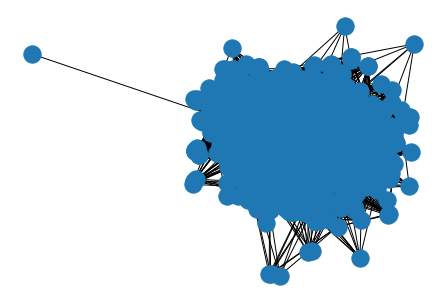

In [16]:
nx.draw(G)

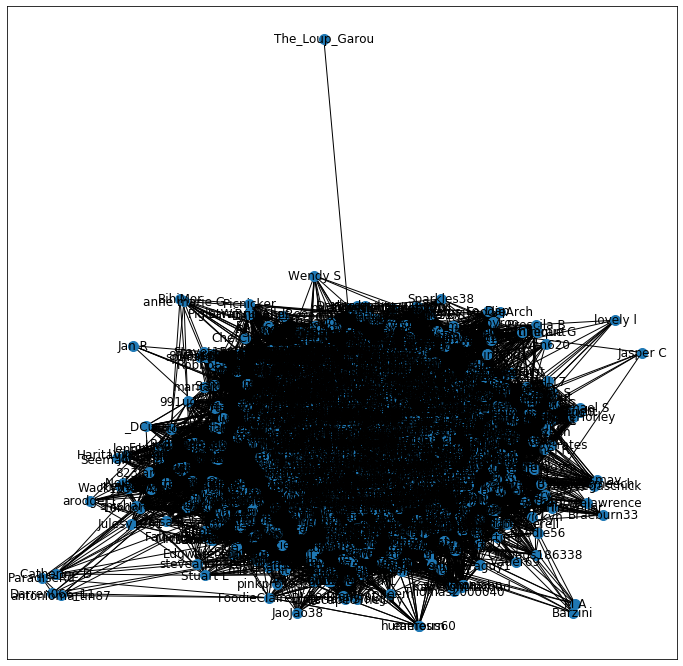

In [17]:
def draw_network(G):
    plt.figure(3,figsize=(12,12)) 
    nx.draw_networkx(G,node_size=100)
draw_network(G)

## What are your hypothesis about features this graph could capture ? 
* **neighborhood/location** people that visits same restaurant could be living in the same area 
* **tastes** : people that eat at same restaurant could be have the same taste
* **activity level**: is there a relation between the number of reviews that one has and the sentiment polarity ? 
* **cultural bias**: may have some impact on the rating one is ready to give 

How would you validate or discard one of these hypothesis ? 
* Taste : Community Detection on graphs
    * Distribution of restaurant type by cluster
    * Topic Extraction of reviews by by cluster
* ...

In [44]:
def get_all_interactions_from(reviewer_pseudo):
    sub_inter =  pd.DataFrame([[pseudo, id_rest["rest_id"]] for pseudo, id_rest in G[reviewer_pseudo].items()], columns=["pseudo", "id_rest"])
    return sub_inter.sort_values(by="id_rest")

get_all_interactions_from("The_Loup_Garou")
#get_all_interactions_from("Catherine D")

,pseudo,id_rest
99,Max98116,g186338-d1137197
101,nickychris,g186338-d1137197
102,oliP21,g186338-d1137197
103,Sinopticus,g186338-d1137197
104,PJT99,g186338-d1137197
...,...,...
25,Georgia B,g186338-d720853
26,87wendywoo,g186338-d720853
27,Porcophile,g186338-d720853
20,Pokumon_London,g186338-d720853


In [45]:
def clean_flatten_list(l):
    final = []
    for subl in l: 
        final += [e.strip() for e in subl]
    return final 

def get_words_from_comment(id_resto):
    return df[df.rest_id == id_resto].review_content_clean.tolist()

id_resto = "g1480935-d2205728"#"g528819-d10490489" #"g1635501-d11777389"
words = get_words_from_comment(id_resto)
final = clean_flatten_list(words)
FreqDist(final).most_common(15)

[('food', 85),
 ('good', 80),
 ('``', 71),
 ('staff', 49),
 ('service', 46),
 ('u', 44),
 ("n't", 43),
 ('restaurant', 41),
 ('time', 40),
 ('menu', 39),
 ('nice', 37),
 ('table', 32),
 ('meal', 32),
 ('arkley', 31),
 ('could', 30)]

# Graph of reviewers

1. Build the training set for Node2vec model by applying `get_node2vec_randomwalks()` 
* Fit Skipgram on your random walks input using gensim implementation of word2vec with `learn_reviewer_embeddings()`
*  Visualize and test the learned representation of reviewers using `most_similar()` api of gensim (e.g. cosine similarity)


In [46]:
interactions.head()

,reviewer_pseudo_x,rest_id,reviewer_pseudo_y
1,David K,g1791615-d1845337,jeffnorthlondon
2,David K,g1791615-d1845337,lenphotographic
3,David K,g1791615-d1845337,kascem
4,David K,g1791615-d1845337,Sallyrb2014
5,David K,g1791615-d1845337,EssexBarnes


In [31]:
#!pip install node2vec

In [34]:
from gensim.models import Word2Vec

In [60]:
from node2vec import Node2Vec

def train_node2vec_model(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=15, num_walks=100, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4) 
    return model

model = train_node2vec_model(G)


Computing transition probabilities: 100%|██████████| 4935/4935 [02:21<00:00, 34.88it/s] 
/usr/local/anaconda3/envs/coursxhec/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [37]:
#model.save('node2vec.pkl')
#n2v = Word2Vec.load("node2vec.pkl")

In [48]:

n2v.wv.most_similar("Wendy S", topn=5)

[('Rod1311', 0.8713041543960571),
 ('peterkirchem', 0.8403115272521973),
 ('Nicked2016', 0.8350304365158081),
 ('Ray G', 0.8258033394813538),
 ('simonlkcheung', 0.7720798850059509)]

In [47]:
get_all_interactions_from("Wendy S")

,pseudo,id_rest
0,589MichaelP,g186338-d928576
17,HullPhil,g186338-d928576
16,Katie P,g186338-d928576
15,Simon O,g186338-d928576
14,sbf1987,g186338-d928576
12,Nick L,g186338-d928576
11,Rachel H,g186338-d928576
10,Chantal V,g186338-d928576
9,pjaye2013,g186338-d928576
13,342SteveO,g186338-d928576


## Visualize the reviewer embedding space

Extract vectors and labels and load it into https://projector.tensorflow.org/

In [64]:
def write_labels_file(model):
    labels = model.wv.vocab.keys()
    with open("test.tsv", "w") as file:
        for l in labels: 
            file.write(l+"\n")
            
def write_vectors_file(model):
    labels = model.wv.vocab.keys()
    with open("vectors.tsv", "w") as file:
        for l in labels: 
            file.write('\t'.join([str(e) for e in model.wv[l].tolist()])+"\n")

<img src="embeddings_space.png"></img>

# 4. Improve your sentiment model coupling reviewer embeddings and word embeddigns

In [49]:
# Going back to Tensorflow notebook

<img src="classif.png"></img>